In [46]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from clinical_evaluation.registration import pipeline, regviz
from clinical_evaluation.utils import preprocess, metrics, ops
from pathlib import Path
import pandas as pd

In [47]:
pipeline = pipeline.EvaluationPipeline()


In [48]:
folder = Path("/home/suraj/Repositories/data/NKI/test_registered/21812310").resolve()
info = Path("/home/suraj/Repositories/data/NKI/test_registered/registration_info.csv").resolve()
df = pd.read_csv(info)


In [49]:
regviz = regviz.RegistrationVisualizer(outdir=folder, save_mode='image+video')

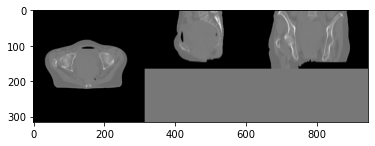

In [50]:
# Load planning CT
dpCT = pipeline.load(folder /"deformed.nrrd")
plt.imshow(regviz.create_2d_views(dpCT), cmap='gray')

In [51]:
slice_fn = lambda x: ops.slice_image(x, (0, 0, 10), (-1, -1, -1))

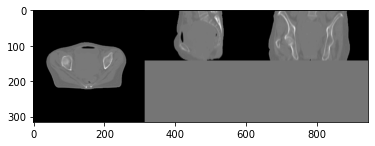

In [52]:
dpCT = slice_fn(dpCT)
plt.imshow(regviz.create_2d_views(dpCT), cmap='gray')

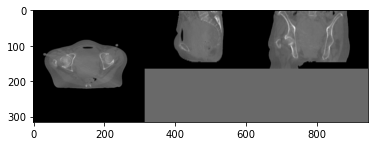

In [53]:
# Load first CBCT in the sequence of CBCTS
CBCT = pipeline.load(folder / "target.nrrd")
plt.imshow(regviz.create_2d_views(CBCT), cmap='gray')

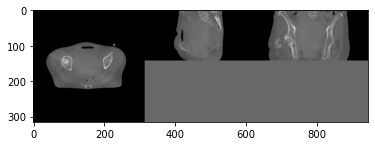

In [54]:
CBCT = slice_fn(CBCT)
plt.imshow(regviz.create_2d_views(CBCT), cmap='gray')

In [55]:
CT = pipeline.load(folder / "source.nrrd")
CT = slice_fn(CT)

In [56]:
# Save CBCT, CT and deformed CT
sitk.WriteImage(CBCT, str(folder / f"target.nrrd"), True)
sitk.WriteImage(CT, str(folder / f"source.nrrd"), True)
sitk.WriteImage(dpCT, str(folder / f"deformed.nrrd"), True)
        
# Save all the propagated contours
rt_masks = {}
for fn in folder.glob("*.nrrd"):
    if fn.stem not in ["target", "source", "deformed"]:
        mask = pipeline.load(fn)
        mask = slice_fn(mask)
        rt_masks[fn.stem] = mask

        sitk.WriteImage(mask, str(folder/ f"{fn.stem}.nrrd"), True)


In [57]:
# Rewrite metrics
metric_dict = metrics.calculate_metrics(CBCT, dpCT)

for label, mask in rt_masks.items():
    mask_metrics = metrics.calculate_metrics(CBCT, dpCT, mask=mask)
    metric_dict.update({f"{k}_{label}": v for k,v in mask_metrics.items()})

metric_dict["save_dir"] = str(folder)
metric_dict["Patient"] = folder.stem


/home/suraj/miniconda3/envs/eval/lib/python3.8/site-packages/scikit_image-0.18.1-py3.8-linux-x86_64.egg/skimage/metrics/_structural_similarity.py:208: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D
/home/suraj/Repositories/clinical-evaluation/src/clinical_evaluation/utils/metrics.py:59: RuntimeWarning: invalid value encountered in double_scalars
  return np.linalg.norm(gt - pred)**2 / np.linalg.norm(gt)**2
/home/suraj/miniconda3/envs/eval/lib/python3.8/site-packages/scikit_image-0.18.1-py3.8-linux-x86_64.egg/skimage/metrics/simple_metrics.py:160: RuntimeWarning: invalid value encountered in true_divide
  return 10 * np.log10((data_range ** 2) / err)


In [58]:
df = df.drop(df[df["Patient"] == int(folder.stem)].index)

In [59]:
df = df.append(metric_dict, ignore_index=True)

In [60]:
df.to_csv(info)

In [61]:
regviz.save_registration_visualizations(CBCT, dpCT)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (315, 599) to (320, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (315, 599) to (320, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (315, 599) to (320, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input ima